In [1]:
!pip install torch torchvision torchaudio torch-geometric networkx


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.2 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch_geometric
from torch_geometric.nn import GCNConv
import networkx as nx
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix


In [7]:
# Create a dummy financial network using NetworkX
def create_dummy_data():
    G = nx.erdos_renyi_graph(n=1000, p=0.01)  # 1000 users, random transactions
    for node in G.nodes():
        G.nodes[node]['label'] = torch.tensor([1 if node % 10 == 0 else 0], dtype=torch.long)  # Fraud label

    # Convert to PyTorch Geometric Data
    edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()
    x = torch.rand((G.number_of_nodes(), 16))  # 16 features per node
    y = torch.tensor([G.nodes[node]['label'] for node in G.nodes()])

    return Data(x=x, edge_index=edge_index, y=y)


In [8]:
class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.relu(x)
        x = self.conv2(x, edge_index)
        return x


In [9]:
def train(model, data, train_idx, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    out = model(data)[train_idx]
    loss = criterion(out, data.y[train_idx])
    loss.backward()
    optimizer.step()
    return loss.item()

def test(model, data, test_idx):
    model.eval()
    with torch.no_grad():
        logits = model(data)
        preds = torch.argmax(logits[test_idx], dim=1)
        acc = accuracy_score(data.y[test_idx].cpu(), preds.cpu())
        return acc, confusion_matrix(data.y[test_idx].cpu(), preds.cpu())

# Prepare data and split into train/test
data = create_dummy_data()
train_idx, test_idx = train_test_split(range(data.num_nodes), test_size=0.2, stratify=data.y)

# Initialize model, optimizer, and loss function
input_dim = data.x.shape[1]
model = GCN(input_dim, 32, 2)  # 32 hidden units, 2 output classes (fraud/no-fraud)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# Train the model
for epoch in range(100):
    loss = train(model, data, train_idx, optimizer, criterion)
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss}')

# Test the model
acc, cm = test(model, data, test_idx)
print(f'Accuracy: {acc}')
print(f'Confusion Matrix:\n{cm}')


Epoch 0, Loss: 0.560573935508728
Epoch 10, Loss: 0.3449150025844574
Epoch 20, Loss: 0.34465324878692627
Epoch 30, Loss: 0.3396546244621277
Epoch 40, Loss: 0.33763065934181213
Epoch 50, Loss: 0.33526816964149475
Epoch 60, Loss: 0.33294418454170227
Epoch 70, Loss: 0.33032673597335815
Epoch 80, Loss: 0.3269837498664856
Epoch 90, Loss: 0.3244858980178833
Accuracy: 0.895
Confusion Matrix:
[[179   1]
 [ 20   0]]


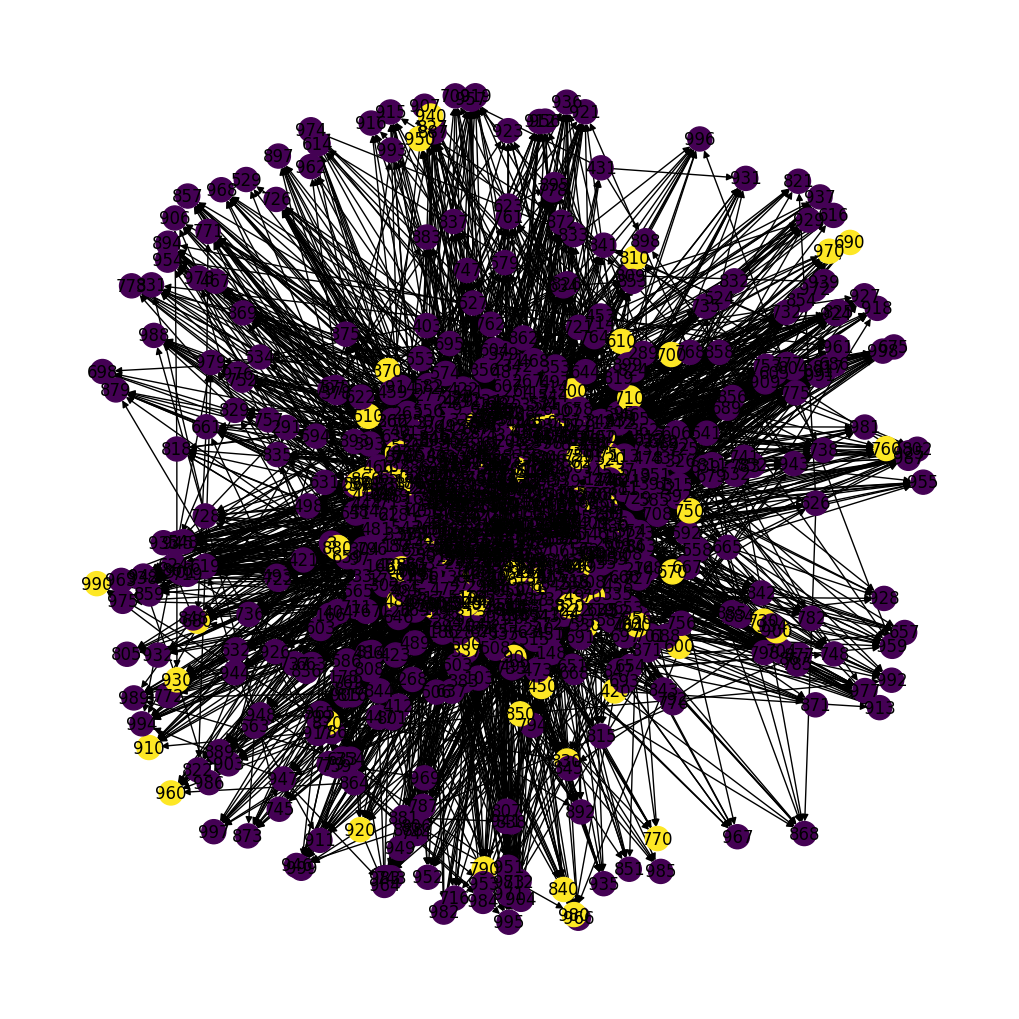

In [11]:
import matplotlib.pyplot as plt
import torch_geometric.utils as tg_utils # Import the necessary module

# Visualize the graph
plt.figure(figsize=(10, 10))
# Call to_networkx() on the data object
G = create_dummy_data() # Get the Data object first
nx_graph = tg_utils.to_networkx(G) # Convert Data object to networkx
nx.draw(nx_graph, node_color=data.y, with_labels=True)
plt.show()

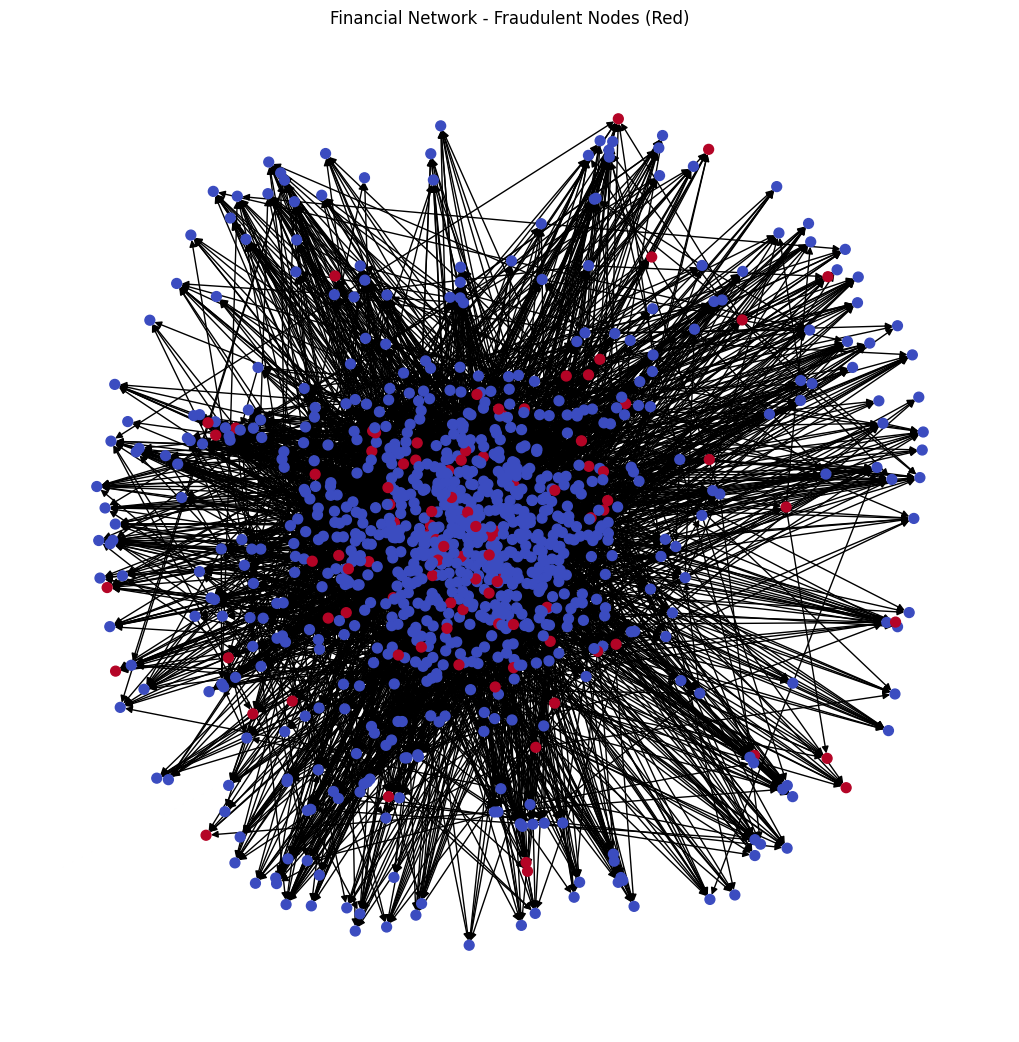

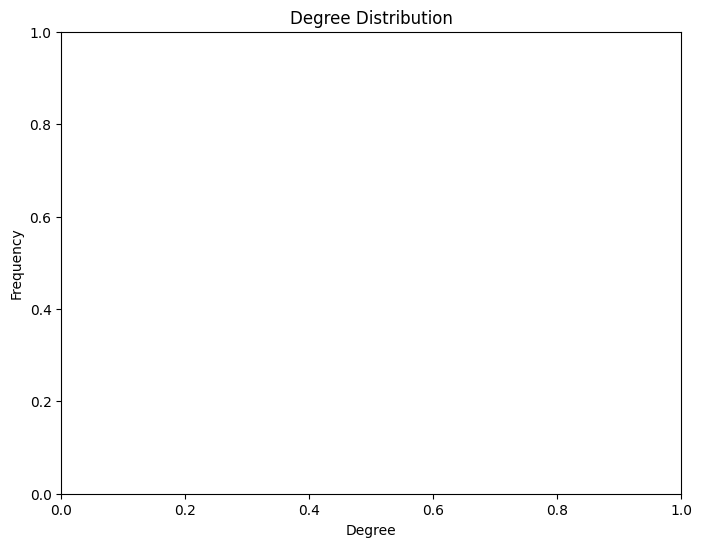

In [13]:
import matplotlib.pyplot as plt
import torch_geometric.utils as tg_utils
import networkx as nx

# Create the data
data = create_dummy_data()
nx_graph = tg_utils.to_networkx(data)

# 1. Visualize the network with node colors based on fraud labels
plt.figure(figsize=(10, 10))
nx.draw(nx_graph, node_color=data.y.cpu().numpy(), cmap="coolwarm", with_labels=False, node_size=50)
plt.title("Financial Network - Fraudulent Nodes (Red)")
plt.show()

# 2. Visualize the degree distribution
degree_sequence = sorted([d for n, d in nx_graph.degree()], reverse=True)
plt.figure(figsize=(8,6))
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.show()
